<a href="https://colab.research.google.com/github/ElektrosStulpas/DeepLearningVU22/blob/main/GMMSecond.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Antra užduotis reikalaus realizuoti vaizdų klasifikavimo ir lokalizacijos modelį.Atsiskaitinėjant pratybų dėstytojas atsiųs testinių vaizdų, su kuriais turėsite pa-demonstruoti, kaip jūsų realizuotas modelis veikia. Atsiskaitymo metu, turėsitegebėti papasakoti, kaip realizuotas, jūsų užduoties varianto konfigūracija t.y.duotas specifinis vaizdų atpažinimo modelis.  Programinės įrangos sprendimągalite naudoti savo nuožiūra.

Mano duomenų klasės: **Human, Horse, Knife**

Reikia nustatyti **klasė,x0,y0,x1,y1**. Čia x0, y0, tai viršutinio kairio kampo koordinatės, x1, y1, tai apatinio dešinio kampo koordinatės

Naudojamas OpenImages V6 duomenų rinkinys (https://storage.googleapis.com/openimages/web/index.html)

Tasks to do:
1. Load up data, preferably single item per picture (possible to delete all multi item pictures, but that reduces data quite a bit)
2. Download pretrained model, throw out last layer, branch it to output a linear layer for classification between 3 given classes. The other branch will be for detection
3. make dataset
4. make training function
5. make validation function

pradžiai pasikonstruot cs failą
img_path, class, koordinatės

mean squared error

DATA LOADING FROM DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import csv

def clean_detections(set_name):
# Delete unneded columns in detections.csv
  with open("/content/drive/MyDrive/oidv6_Data/boxes/" + set_name +"-annotations-bbox.csv","r") as source:
      rdr= csv.reader( source )
      with open("/content/drive/MyDrive/oidv6_Data/boxes/" + set_name +"-annotations-bboxCLEAN.csv","w") as result:
          wtr= csv.writer( result )
          for r in rdr:
            if r[2] == "LabelName": wtr.writerow( (r[0], "Label", r[4], r[5], r[6], r[7]) )

            if r[2] == "/m/01g317" and os.path.exists("/content/drive/MyDrive/oidv6_Data/" + set_name +"/person/" + r[0] + ".jpg"):
              wtr.writerow( (r[0], 0, r[4], r[5], r[6], r[7]) ) # 0 - Person class
            elif r[2] == "/m/03k3r" and os.path.exists("/content/drive/MyDrive/oidv6_Data/" + set_name +"/horse/" + r[0] + ".jpg"):
              wtr.writerow( (r[0], 1, r[4], r[5], r[6], r[7]) ) # 1 - Horse class
            elif r[2] == "/m/04ctx" and os.path.exists("/content/drive/MyDrive/oidv6_Data/" + set_name +"/knife/" + r[0] + ".jpg"):
              wtr.writerow( (r[0], 2, r[4], r[5], r[6], r[7]) ) # 2 - Knife class

In [ ]:
#Alternative data load for oidv6
import pandas as pd
import os

META_TRAIN_PATH = "/content/drive/MyDrive/oidv6_Data/boxes/train-annotations-bboxCLEAN.csv"
META_VALID_PATH = "/content/drive/MyDrive/oidv6_Data/boxes/validation-annotations-bboxCLEAN.csv"
META_TEST_PATH = "/content/drive/MyDrive/oidv6_Data/boxes/test-annotations-bboxCLEAN.csv"
root_path = "/content/drive/MyDrive/oidv6_Data"

def load_data_from_driveOIDV6(root_path, metadata_path, set_name):
  if not os.path.exists(metadata_path):
    clean_detections(set_name)
  
  temp_paths = []
  data = pd.read_csv(metadata_path)
  # print(data.nunique())
  data.drop_duplicates(subset=["ImageID"], keep=False, inplace=True) #drop items with more than one label (meaning more than one target to avoid model confusion)
  data.reset_index(drop=True, inplace=True)

  data.loc[data.Label == 0, "ImageID"] = "person/" + data.ImageID
  data.loc[data.Label == 1, "ImageID"] = "horse/" + data.ImageID
  data.loc[data.Label == 2, "ImageID"] = "knife/" + data.ImageID

  for img_id in data.ImageID:
    temp_paths.append(os.path.join(root_path, set_name, img_id + ".jpg"))

  data.ImageID = temp_paths
  # print("===================")
  # print(data.nunique())

  return data


train_df = load_data_from_driveOIDV6(root_path, META_TRAIN_PATH, 'train')
valid_df = load_data_from_driveOIDV6(root_path, META_VALID_PATH, 'validation')
train_df = pd.concat([train_df, valid_df], ignore_index=True)
test_df = load_data_from_driveOIDV6(root_path, META_TEST_PATH, 'test')

SANITY CHECKS FOR LOADED DATA

In [ ]:
print(len(train_df.index))
train_df.head()
# I don't get why there's 104395 of single item photos when I downloaded only 10000

2111


,ImageID,Label,XMin,XMax,YMin,YMax
0,/content/drive/MyDrive/oidv6_Data/train/person...,0,0.006250,0.532500,0.084428,0.999062
1,/content/drive/MyDrive/oidv6_Data/train/person...,0,0.000000,0.262719,0.114375,0.680625
2,/content/drive/MyDrive/oidv6_Data/train/person...,0,0.486667,0.625000,0.611250,0.814375
3,/content/drive/MyDrive/oidv6_Data/train/person...,0,0.276667,0.426667,0.206667,0.746667
4,/content/drive/MyDrive/oidv6_Data/train/person...,0,0.074375,0.114375,0.676004,0.704949


In [ ]:
print(len(valid_df.index))
valid_df.head()

797


,ImageID,Label,XMin,XMax,YMin,YMax
0,/content/drive/MyDrive/oidv6_Data/validation/p...,0,0.734513,0.932153,0.000000,0.369469
1,/content/drive/MyDrive/oidv6_Data/validation/p...,0,0.000000,0.591176,0.000000,0.997783
2,/content/drive/MyDrive/oidv6_Data/validation/p...,0,0.000000,0.441964,0.119048,0.764881
3,/content/drive/MyDrive/oidv6_Data/validation/p...,0,0.000000,0.895312,0.116667,1.000000
4,/content/drive/MyDrive/oidv6_Data/validation/p...,0,0.264583,0.812500,0.179688,0.687500


In [ ]:
print(len(test_df.index))
test_df.head()

1292


,ImageID,Label,XMin,XMax,YMin,YMax
0,/content/drive/MyDrive/oidv6_Data/test/person/...,0,0.321875,0.570312,0.158333,1.000000
1,/content/drive/MyDrive/oidv6_Data/test/person/...,0,0.254688,0.464062,0.291667,0.616667
2,/content/drive/MyDrive/oidv6_Data/test/person/...,0,0.815006,0.921087,0.569270,0.828715
3,/content/drive/MyDrive/oidv6_Data/test/person/...,0,0.087500,0.193750,0.050000,0.183333
4,/content/drive/MyDrive/oidv6_Data/test/person/...,0,0.000000,0.919236,0.000000,1.000000


DATASET (with trasnforms used for the images loaded)

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import torch

class ImagesDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_dir = self.df.loc[idx, "ImageID"]
    img = Image.open(img_dir).convert("RGB")

    img_label = torch.tensor(float(self.df.loc[idx, "Label"]))

    x0 = float(self.df.loc[idx, "XMin"])
    y0 = float(self.df.loc[idx, "YMin"])
    x1 = float(self.df.loc[idx, "XMax"])
    y1 = float(self.df.loc[idx, "YMax"])

    if self.transform is not None:
      img = self.transform(img)

    return img, img_label, torch.tensor([x0, y0, x1, y1])


In [ ]:
import torchvision.transforms as transforms
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )

invTransform = transforms.Compose(
        [
            transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225)),
            transforms.ToPILImage()
        ]
    )

In [ ]:
trainDS = ImagesDataset(train_df, transform)
validDS = ImagesDataset(valid_df, transform)
testDS = ImagesDataset(test_df, transform)

MODEL

In [ ]:
#Model
import torch
from torchvision import models
from torch.nn import init
import torch.nn as nn
import torch.nn.functional as F

class Classifier_Detector(nn.Module):
  def __init__(self, pretrained_model):
    super().__init__()

    self.conv = torch.nn.Sequential(*list(pretrained_model.children())[:-1]) #drop the last layer and assign it as the convolutional layers
    self.fc = nn.Linear(in_features=2048, out_features=3) #classes layer

    self.bbox = torch.nn.Sequential(
                                nn.Linear(2048, 240),
                                nn.BatchNorm1d(240),
                                nn.ReLU(),
                                nn.Dropout(0.05),
                                nn.Linear(240, 120),
                                nn.BatchNorm1d(120),
                                nn.ReLU(),
                                nn.Dropout(0.05),
                                nn.Linear(120, 4)
                                )
    

    # self.fc1 = nn.Linear(in_features=2048, out_features=1) #coordinates layer
    # self.fc2 = nn.Linear(in_features=2048, out_features=1) #coordinates layer
    # self.fc3 = nn.Linear(in_features=2048, out_features=1) #coordinates layer
    # self.fc4 = nn.Linear(in_features=2048, out_features=1) #coordinates layer

  def forward(self, x):
        #pass our data through pretrained model, get out 2048 features
        branch = self.conv(x)

        x = nn.Dropout(0.15)(branch)
        x = nn.ReLU()(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        # x = nn.Dropout(0.05)(x)
        x = nn.ReLU()(x)
        classes_pred = F.softmax(x, dim=1)

        x = nn.Dropout(0.1)(branch)
        x = nn.ReLU()(x)
        x = x.view(x.shape[0], -1)
        bbox_coord = self.bbox(x)
        # x = nn.Dropout(0.1)(branch)
        # x = nn.ReLU()(x)
        # x = x.view(x.shape[0], -1)
        # x0_pred = self.fc1(x)

        # x = nn.Dropout(0.1)(branch)
        # x = nn.ReLU()(x)
        # x = x.view(x.shape[0], -1)
        # y0_pred = self.fc2(x)

        # x = nn.Dropout(0.1)(branch)
        # x = nn.ReLU()(x)
        # x = x.view(x.shape[0], -1)
        # x1_pred = self.fc3(x)

        # x = nn.Dropout(0.1)(branch)
        # x = nn.ReLU()(x)
        # x = x.view(x.shape[0], -1)
        # y1_pred = self.fc4(x)

        return classes_pred, bbox_coord#torch.cat([x0_pred, y0_pred, x1_pred, y1_pred], -1)

pretrained_resnet50_model = models.resnet50(pretrained=True)
model = Classifier_Detector(pretrained_resnet50_model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
def set_model_to_device(model):
  dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  mdl = model.to(dvc)
  return mdl, dvc

model, device = set_model_to_device(model)

TRAINING

In [ ]:
def IOU_metric(coord1, coord2):
  box_areas = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]))

  coord1_areas = box_areas(coord1)
  coord2_areas = box_areas(coord2)

  intersection_upperlefts = torch.max(coord1[:, :2], coord2[:, :2])
  intersection_lowerrights = torch.min(coord1[:, 2:], coord2[:, 2:])

  intersectionWH = (intersection_lowerrights - intersection_upperlefts).clamp(min=0)

  intersection_areas = intersectionWH[:, 0] * intersectionWH[:, 1]
  union_areas = coord1_areas + coord2_areas - intersection_areas

  iou = intersection_areas / union_areas
  return iou.mean().item()


def after_epoch_validation(model, valid_dl):
  model.eval()
  with torch.no_grad():
    correct_prediction = 0
    total_prediction = 0
    val_loss = 0.0
    val_iou = 0.0
    for i , data in enumerate(valid_dl):
      images, labels, coords = data[0].to(device), data[1].to(device), data[2].to(device)
      outputs = model(images)

      iou = IOU_metric(outputs[1], coords)
      val_iou += iou

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs[0],1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]

    val_num_batches = len(valid_dl)
    val_acc = correct_prediction/total_prediction
    avg_val_iou = val_iou/val_num_batches

    print(f"Validation MIOU: {avg_val_iou:.2f}, validation accuracy: {val_acc:.2f}")
  model.train()


def training(model, train_dl, valid_dl, loss1, loss2, optimizer, scheduler, num_epochs):
  for epoch in range(1, num_epochs+1):
      running_loss1 = 0.0
      running_loss2 = 0.0
      running_iou = 0.0
      correct_prediction = 0
      total_prediction = 0
      
      model.train(True)

      for i , data in enumerate(train_dl):
          images, labels, coords = data[0].to(device), data[1].to(device), data[2].to(device)

          # clear the gradients of all optimized variables
          optimizer.zero_grad()
          # forward pass: compute predicted outputs by passing inputs to the model
          outputs = model(images)
          

          loss_1 = loss1(outputs[0], labels.long())
          loss_2 = loss2(outputs[1], coords)
          loss = loss_1 + loss_2

          iou = IOU_metric(outputs[1], coords)
        
          # # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # # perform a single optimization step (parameter update)
          optimizer.step()

          running_loss1 += loss_1.item()*images.size(0)
          running_loss2 += loss_2.item()*images.size(0)
          running_iou += iou

          _, prediction = torch.max(outputs[0],1)
          correct_prediction += (prediction == labels).sum().item()
          total_prediction += prediction.shape[0]

          # print(f"Prediction: {prediction}")
          # print(f"Labels: {labels}")
          # print(f"Correct prediction: {correct_prediction}")
          # print(f"Total prediction: {total_prediction}")
          # print("===========================")

      
      num_batches = len(train_dl)
      avg_loss_classes = running_loss1 / num_batches
      avg_loss_coords = running_loss2 / num_batches
      avg_iou = running_iou / num_batches
      acc = correct_prediction/total_prediction
      print(f'Epoch: {epoch}, Class loss: {avg_loss_classes:.2f}, Coords loss: {avg_loss_coords:.2f}, Coords MIOU: {avg_iou:.2f}, Accuracy: {acc:.2f}')

      after_epoch_validation(model, valid_dl)

      # scheduler.step()

In [ ]:
def fine_tune_training(model, train_dataset, valid_dataset, learn_rate, batch_size=16, num_epochs=7, param_group=True):
  train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle = True, drop_last=True)
  valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, shuffle = True, drop_last=True)

  criterion_for_class = nn.CrossEntropyLoss().cuda()
  criterion_for_coords = nn.MSELoss().cuda()
  if param_group:
    all_params = [param for name, param in model.named_parameters()]
    pretrained_params = all_params[:-6*2]
    all_the_rest_params = all_params[-6*2:]
    optimizer = torch.optim.Adam([{'params':pretrained_params},
                                  {'params':model.fc.parameters(),
                                   'lr':learn_rate * 0}, #usual is 10
                                  {'params':model.bbox.parameters(),
                                   'lr':learn_rate * 60}], # while training can vary between 200-50 multiplier
                                 lr=learn_rate)
  else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

  training(model, train_dl, valid_dl, criterion_for_class, criterion_for_coords, optimizer, scheduler, num_epochs)

In [ ]:
paramNames = [name for name, param in model.named_parameters()]
print(paramNames[:-6*2])
print(paramNames[-6*2:])
print(len(paramNames))

['conv.0.weight', 'conv.1.weight', 'conv.1.bias', 'conv.4.0.conv1.weight', 'conv.4.0.bn1.weight', 'conv.4.0.bn1.bias', 'conv.4.0.conv2.weight', 'conv.4.0.bn2.weight', 'conv.4.0.bn2.bias', 'conv.4.0.conv3.weight', 'conv.4.0.bn3.weight', 'conv.4.0.bn3.bias', 'conv.4.0.downsample.0.weight', 'conv.4.0.downsample.1.weight', 'conv.4.0.downsample.1.bias', 'conv.4.1.conv1.weight', 'conv.4.1.bn1.weight', 'conv.4.1.bn1.bias', 'conv.4.1.conv2.weight', 'conv.4.1.bn2.weight', 'conv.4.1.bn2.bias', 'conv.4.1.conv3.weight', 'conv.4.1.bn3.weight', 'conv.4.1.bn3.bias', 'conv.4.2.conv1.weight', 'conv.4.2.bn1.weight', 'conv.4.2.bn1.bias', 'conv.4.2.conv2.weight', 'conv.4.2.bn2.weight', 'conv.4.2.bn2.bias', 'conv.4.2.conv3.weight', 'conv.4.2.bn3.weight', 'conv.4.2.bn3.bias', 'conv.5.0.conv1.weight', 'conv.5.0.bn1.weight', 'conv.5.0.bn1.bias', 'conv.5.0.conv2.weight', 'conv.5.0.bn2.weight', 'conv.5.0.bn2.bias', 'conv.5.0.conv3.weight', 'conv.5.0.bn3.weight', 'conv.5.0.bn3.bias', 'conv.5.0.downsample.0.weigh

In [ ]:
# ENTRY POINT FOR TRAINING # THINGS TO STILL TRY FOR IMPROVEMENT:
# weight_decay/scheduler for lr decrease/ reducing class loss pivot more updates towards coords
fine_tune_training(model, trainDS, testDS, 5e-5, num_epochs=2, batch_size=32)

Epoch: 1, Class loss: 20.98, Coords loss: 0.21, Coords MIOU: 0.61, Accuracy: 0.81
Validation MIOU: 0.50, validation accuracy: 0.86
Epoch: 2, Class loss: 20.95, Coords loss: 0.18, Coords MIOU: 0.63, Accuracy: 0.81
Validation MIOU: 0.52, validation accuracy: 0.86


MODEL SAVING AND LOADING

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/oidv6_Data/modelOver50MIOU.pth')

In [ ]:
model = Classifier_Detector(pretrained_resnet50_model)
model.load_state_dict(torch.load('/content/drive/MyDrive/oidv6_Data/modelOver50MIOU.pth'))
set_model_to_device(model)

INFERENCE

In [ ]:
#Validation MIOU check after training
infer_dl = torch.utils.data.DataLoader(testDS, batch_size=32, num_workers=2, shuffle = True, drop_last=True)
after_epoch_validation(model, infer_dl)

Validation MIOU: 0.52, validation accuracy: 0.85


In [ ]:
import matplotlib.pyplot as plt

def draw_bbox_image(img, coords):
  bbox = coords.cpu()

  t_image = invTransform(img)

  fig = plt.imshow(t_image)
  fig.axes.add_patch(plt.Rectangle(xy=(bbox[0]*356, bbox[1]*356), width=(bbox[2]-bbox[0])*356, height=(bbox[3]-bbox[1])*356, fill=False, edgecolor='red', linewidth=2))
  plt.show()

def class_name(prediction):
  classDict = {0:"Person", 1:"Horse", 2:"Knife"}
  return classDict[prediction.item()]


def inference(model, ds, dataset_image_id=0):
  model.eval()
  with torch.no_grad():

    data = ds[dataset_image_id]
    img, label, coords = data[0].to(device), data[1].to(device), data[2].to(device)

    print("Original data:")
    draw_bbox_image(img, coords) # see the expected outcome
    print(f"Class: {class_name(label)}")

    sample_img = img.unsqueeze(0)
    outputs = model(sample_img)
    # print(f"outputs: {outputs}")
    _, prediction = torch.max(outputs[0],1)
  model.train()

  print("=================")
  print("Predicted data:")
  draw_bbox_image(img, outputs[1][0])
  print(f"Class predicted: {class_name(prediction)}")


Original data:


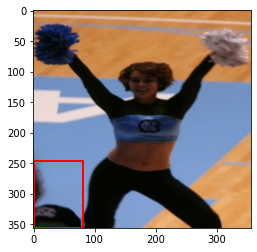

Class: Person
Predicted data:


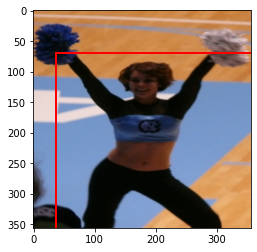

Class predicted: Person


In [ ]:
inference(model, testDS, 24) #24, 52

In [ ]:
len(testDS)

1292

UTILITIES

In [ ]:
#also possible to do data
# https://github.com/DmitryRyumin/OIDv6 
!pip install oidv6
!oidv6 downloader en --dataset drive/MyDrive/oidv6_Data --multi-classes --type_data all --classes person horse knife --limit 3000

In [ ]:
!pip install fiftyone
!pip install opencv-python-headless==4.5.4.60

import fiftyone as fo
import fiftyone.zoo as foz

test_dataset = fo.zoo.load_zoo_dataset(
              "open-images-v6",
              split="test",
              label_types=["detections", "classifications"],
              classes=["Person", "Horse","Knife"], # Human is not a valid class in the dataset
              max_samples=2000,
          )
train_dataset = fo.zoo.load_zoo_dataset(
              "open-images-v6",
              split="train",
              label_types=["detections", "classifications"],
              classes=["Person", "Horse","Knife"], # Human is not a valid class in the dataset
              max_samples=10000,
          )
validation_dataset = fo.zoo.load_zoo_dataset(
              "open-images-v6",
              split="validation",
              label_types=["detections", "classifications"],
              classes=["Person", "Horse","Knife"], # Human is not a valid class in the dataset
              max_samples=2000,
          )

In [ ]:
session = fo.launch_app(test_dataset)

In [ ]:
session.dataset = test_dataset

In [ ]:
test_dataset.delete()

In [ ]:
from google.colab import files
files.download("/root/file.zip")

In [ ]:
!ls ../root

In [ ]:
def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

print(get_dir_size('/content/drive/MyDrive/open-images-v6'))
# 8551240409, which is 8.5GB

In [ ]:
!zip -r /root/file.zip /root/fiftyone

In [ ]:
import pandas as pd
import os

META_TRAIN_PATH = "/content/drive/MyDrive/open-images-v6/train/labels/detections_clean.csv"
META_VALID_PATH = "/content/drive/MyDrive/open-images-v6/validation/labels/detections_clean.csv"
META_TEST_PATH = "/content/drive/MyDrive/open-images-v6/test/labels/detections_clean.csv"
root_path = "/content/drive/MyDrive/open-images-v6"

def load_data_from_drive(root_path, metadata_path, set_name):
  classes = ('person', 'horse', 'knife')
  temp_paths = []
  data = pd.read_csv(metadata_path)
  data.drop_duplicates(subset=["ImageID"], keep=False, inplace=True) #drop items with more than one label (meaning more than one target to avoid model confusion)
  data.reset_index(drop=True, inplace=True)

  for img_id in data.ImageID:
    temp_paths.append(os.path.join(root_path, set_name + "/data/" + img_id + ".jpg"))

  data.ImageID = temp_paths

  return data


train_df = load_data_from_drive(root_path, META_TRAIN_PATH, 'train')
valid_df = load_data_from_drive(root_path, META_VALID_PATH, 'validation')
test_df = load_data_from_drive(root_path, META_TEST_PATH, 'test')

In [ ]:
#Function to sift through the data and leave only the relevant classes
import csv
import os

def clean_detections(set_name):
# Delete unneded columns in detections.csv
  with open("/content/drive/MyDrive/open-images-v6/" + set_name +"/labels/detections.csv","r") as source:
      rdr= csv.reader( source )
      with open("/content/drive/MyDrive/open-images-v6/" + set_name +"/labels/detections_clean.csv","w") as result:
          wtr= csv.writer( result )
          for r in rdr:
            if r[2] == "LabelName": wtr.writerow( (r[0], "Label", r[4], r[5], r[6], r[7]) )

            if r[2] == "/m/01g317" or r[2] == "/m/03k3r" or r[2] == "/m/04ctx":
              if os.path.exists("/content/drive/MyDrive/open-images-v6/" + set_name +"/data/" + r[0] + ".jpg"):
                if r[2] == "/m/01g317":
                  wtr.writerow( (r[0], 0, r[4], r[5], r[6], r[7]) ) # 0 - Person class
                elif r[2] == "/m/03k3r":
                  wtr.writerow( (r[0], 1, r[4], r[5], r[6], r[7]) ) # 1 - Horse class
                elif r[2] == "/m/04ctx":
                  wtr.writerow( (r[0], 2, r[4], r[5], r[6], r[7]) ) # 2 - Knife class
              else:
                  print("image" + r[0] + " no exist")


clean_detections("test")

In [ ]:
import os
print(os.path.exists("/content/drive/MyDrive/open-images-v6/test/data/" + "0a0b3287f3246d49" + ".jpg"))

In [ ]:
#Finder for classes-keys
import csv

with open("/content/drive/MyDrive/open-images-v6/train/metadata/classes.csv","r") as source:
  rdr = csv.reader(source)
  for row in rdr:
   if row[1] == "Knife":
     print(f"key {row[0]} for class {row[1]}")

In [ ]:
drive.flush_and_unmount() #save to drive when finishing work